In [6]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install seaborn

1. Cargar los datasets

In [9]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------
# Cargar datasets reducidos
# -------------------------------------
DATA_DIR = "DatasetReducido"
datasets = {
    "FaultFree_Training": pd.read_csv(os.path.join(DATA_DIR, "FaultFree_Training_reduced.csv")),
    "FaultFree_Testing": pd.read_csv(os.path.join(DATA_DIR, "FaultFree_Testing_reduced.csv")),
    "Faulty_Training": pd.read_csv(os.path.join(DATA_DIR, "Faulty_Training_reduced.csv")),
    "Faulty_Testing": pd.read_csv(os.path.join(DATA_DIR, "Faulty_Testing_reduced.csv")),
}
print("Datasets CSV cargados correctamente.")

# Comprobar clases
for name, df in datasets.items():
    print(f"{name} - fault_present value counts:\n", df["fault_present"].value_counts(), "\n")

Datasets CSV cargados correctamente.
FaultFree_Training - fault_present value counts:
 fault_present
0    10000
Name: count, dtype: int64 

FaultFree_Testing - fault_present value counts:
 fault_present
0    19200
Name: count, dtype: int64 

Faulty_Training - fault_present value counts:
 fault_present
1    100000
Name: count, dtype: int64 

Faulty_Testing - fault_present value counts:
 fault_present
1    192000
Name: count, dtype: int64 



In [10]:
# -------------------------------------
# Combinar Faulty + FaultFree para entrenamiento
# -------------------------------------
df_train = pd.concat([datasets["FaultFree_Training"], datasets["Faulty_Training"]], ignore_index=True)
df_test  = pd.concat([datasets["FaultFree_Testing"], datasets["Faulty_Testing"]], ignore_index=True)

print("Distribución clases entrenamiento:")
print(df_train["fault_present"].value_counts())
print("Distribución clases test:")
print(df_test["fault_present"].value_counts())

Distribución clases entrenamiento:
fault_present
1    100000
0     10000
Name: count, dtype: int64
Distribución clases test:
fault_present
1    192000
0     19200
Name: count, dtype: int64


In [11]:
# -------------------------------------
# Normalizador solo con datos normales
# -------------------------------------
process_vars = [f"xmeas_{i}" for i in range(1, 42)]
actuator_vars = [f"xmv_{i}" for i in range(1, 12)]
all_vars = process_vars + actuator_vars

scaler = StandardScaler()
scaler.fit(df_train[df_train["fault_present"]==0][all_vars])  # entrenar solo con normales
print("Normalizador entrenado únicamente con datos sin fallo.")

Normalizador entrenado únicamente con datos sin fallo.


In [12]:
# -------------------------------------
# Aplicar ingeniería de características
# -------------------------------------
def add_temporal_features(df, variables, ventanas=[5,10]):
    df = df.sort_values(["simulationRun", "sample"]).copy()
    nuevas = {}

    for var in variables:
        nuevas[f"{var}_diff1"] = df.groupby("simulationRun")[var].diff()
        for w in ventanas:
            nuevas[f"{var}_ma{w}"] = df.groupby("simulationRun")[var].rolling(window=w, min_periods=1).mean().reset_index(level=0, drop=True)
            nuevas[f"{var}_std{w}"] = df.groupby("simulationRun")[var].rolling(window=w, min_periods=1).std().reset_index(level=0, drop=True)
    
    df_new = pd.DataFrame(nuevas)
    return pd.concat([df, df_new], axis=1)

In [13]:
def add_fault_timing_features(df):
    df = df.sort_values(["simulationRun", "sample"]).copy()
    df["time_since_fault"] = df.groupby("simulationRun")["fault_present"].cumsum()
    df["time_since_fault"] = df["time_since_fault"].where(df["fault_present"]==1, 0)
    df["fault_stage"] = 0
    positive_idx = df["fault_present"]==1
    df.loc[positive_idx,"fault_stage"] = (df.loc[positive_idx,"time_since_fault"] // 10).astype(int)
    return df

In [14]:
# Aplicar a entrenamiento y test
df_train = add_temporal_features(df_train, all_vars)
df_train = add_fault_timing_features(df_train)
df_test  = add_temporal_features(df_test, all_vars)
df_test  = add_fault_timing_features(df_test)

# Escalar variables originales
df_train[[f"{v}_scaled" for v in all_vars]] = scaler.transform(df_train[all_vars].fillna(0))
df_test[[f"{v}_scaled" for v in all_vars]] = scaler.transform(df_test[all_vars].fillna(0))

print("Ingeniería de características aplicada correctamente.")

Ingeniería de características aplicada correctamente.


In [15]:
# -------------------------------------
# Guardar datasets finales
# -------------------------------------
OUTPUT_DIR = "DatasetProcesado"
os.makedirs(OUTPUT_DIR, exist_ok=True)

df_train.to_csv(os.path.join(OUTPUT_DIR,"TEP_features_train.csv"), index=False)
df_test.to_csv(os.path.join(OUTPUT_DIR,"TEP_features_test.csv"), index=False)

print("CSV finales guardados en DatasetProcesado.")

CSV finales guardados en DatasetProcesado.


2. Comprobación

In [16]:
print("=== NANs por columna (train) ===")
na_train = df_train.isna().sum()
print(na_train[na_train > 0].sort_values(ascending=False).head(30))

=== NANs por columna (train) ===
xmeas_1_diff1     20
xmeas_1_std5      20
xmeas_1_std10     20
xmeas_2_diff1     20
xmeas_2_std5      20
xmeas_2_std10     20
xmeas_3_diff1     20
xmeas_3_std5      20
xmeas_3_std10     20
xmeas_4_diff1     20
xmeas_4_std5      20
xmeas_4_std10     20
xmeas_5_diff1     20
xmeas_5_std5      20
xmeas_5_std10     20
xmeas_6_diff1     20
xmeas_6_std5      20
xmeas_6_std10     20
xmeas_7_diff1     20
xmeas_7_std5      20
xmeas_7_std10     20
xmeas_8_diff1     20
xmeas_8_std5      20
xmeas_8_std10     20
xmeas_9_diff1     20
xmeas_9_std5      20
xmeas_9_std10     20
xmeas_10_diff1    20
xmeas_10_std5     20
xmeas_10_std10    20
dtype: int64


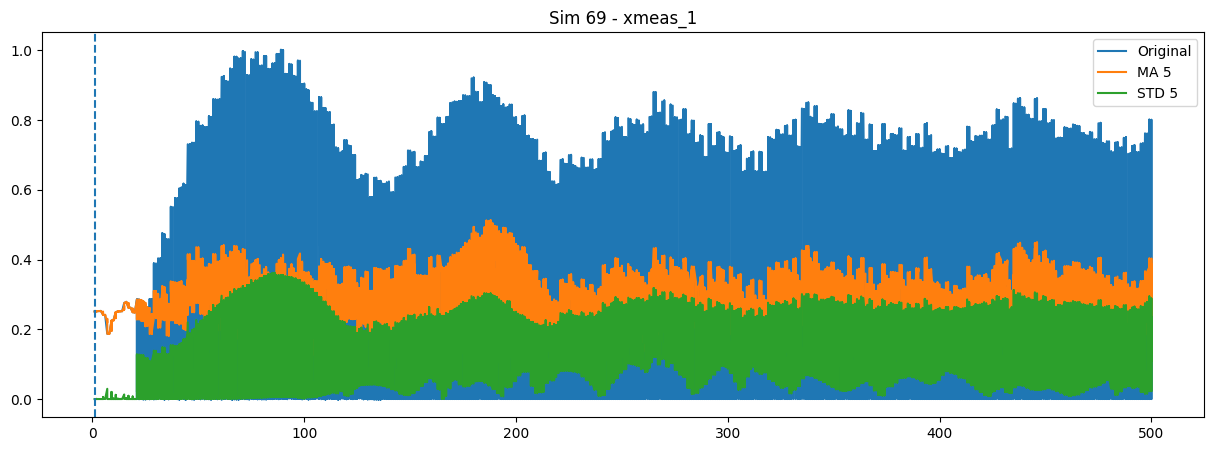

In [17]:
import matplotlib.pyplot as plt

def plot_temporal(run, variable):
    df = df_train[df_train["simulationRun"]==run].sort_values("sample")

    plt.figure(figsize=(15,5))
    plt.plot(df["sample"], df[variable], label="Original")
    plt.plot(df["sample"], df[f"{variable}_ma5"], label="MA 5")
    plt.plot(df["sample"], df[f"{variable}_std5"], label="STD 5")
    
    # Inicio del fallo
    if df["fault_present"].max()==1:
        x0 = df[df["fault_present"]==1]["sample"].min()
        plt.axvline(x=x0, linestyle="--")
    
    plt.title(f"Sim {run} - {variable}")
    plt.legend()
    plt.show()

plot_temporal(run=69, variable="xmeas_1")

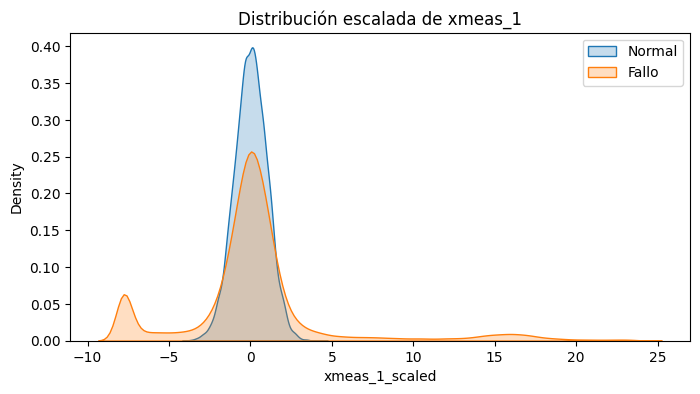

In [18]:
var = "xmeas_1"
plt.figure(figsize=(8,4))
sns.kdeplot(df_train[df_train.fault_present==0][f"{var}_scaled"], fill=True, label="Normal")
sns.kdeplot(df_train[df_train.fault_present==1][f"{var}_scaled"], fill=True, label="Fallo")
plt.title(f"Distribución escalada de {var}")
plt.legend()
plt.show()

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

feature_cols = [c for c in df_train.columns if any(k in c for k in ["diff1","ma","std","fault_stage","time_since_fault"])]
X = df_train[feature_cols].fillna(0)
y = df_train["fault_present"]

X_tr, X_te, y_tr, y_te = train_test_split(X,y,test_size=0.3,random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_tr,y_tr)

importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(importances.head(20))
print("AUC:", roc_auc_score(y_te, rf.predict_proba(X_te)[:,1]))

time_since_fault    0.232773
fault_stage         0.183831
xmeas_12_std5       0.023635
xmeas_7_std10       0.019449
xmeas_5_std5        0.017752
xmeas_16_std10      0.016942
xmeas_18_std5       0.015990
xmv_8_std5          0.015053
xmeas_13_std10      0.013695
xmv_7_std5          0.013513
xmv_5_diff1         0.012502
xmeas_7_std5        0.011643
xmeas_15_std5       0.010685
xmv_3_std10         0.009744
xmeas_14_std5       0.009612
xmeas_1_std10       0.009566
xmv_5_std10         0.009537
xmeas_11_std10      0.009074
xmeas_20_diff1      0.008995
xmeas_13_diff1      0.008733
dtype: float64
AUC: 1.0


In [20]:
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

print("\nEjemplo de columnas creadas:")
cols_example = [c for c in df_train.columns if "ma5" in c][:5]
print(cols_example)

Train shape: (110000, 370)
Test shape: (211200, 370)

Ejemplo de columnas creadas:
['xmeas_1_ma5', 'xmeas_2_ma5', 'xmeas_3_ma5', 'xmeas_4_ma5', 'xmeas_5_ma5']
